### Подготовка данных

In [1]:
# Подключение пакетов
import torch
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

#Загрузка английского языка
nlp = spacy.load('en')

In [2]:
# Инициируем экземпляры класса с помощью токенизатора
TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

# Загружаем дынные с помощью torchtext
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split()

In [3]:
# Ограничиваем размер словаря
MAX_VOCAB_SIZE = 30_000

# Строим словарь
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 # Load pretrained embeddings
                 vectors = "glove.6B.100d", 
                 # Set unknown vectors
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [4]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Создаем итераторы для использования при обучении/оценке/тестировании модели
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Создаем вложения слов из входных данных     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Задаем свертки
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Добавляем полносвязный слой для окончательных прогнозов
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Отбрасываем некоторые узлы чтобы повысить надежность обучения
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):  
        # Получаем вложения слов и формируем их для сверток
        embedded = self.embedding(text).unsqueeze(1)
        
        # Применяем функцию активации
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        # Cлой субдискретизации(poolling)
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Cлой регуляризации(dropout)
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

## Инициализация предварительно обученной модели

In [6]:
# Размер словаря
INPUT_DIM = len(TEXT.vocab)

# Размер вектора
EMBEDDING_DIM = 100

# Число фильтров
N_FILTERS = 100

# N-граммы, которые мы анализируем с помощью фильтров
FILTER_SIZES = [1, 2, 3, 4, 5]

# Вывод линейного слоя(вероятность отрицательного отзыва)
OUTPUT_DIM = 1

# Доля выпадающих значений
DROPOUT = 0.5

In [7]:
# обнуление начальных весов токенов
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Инициализируем модель и загружаем предварительно обученные вложения
model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, 
            N_FILTERS, FILTER_SIZES, 
            OUTPUT_DIM, DROPOUT, PAD_IDX)

model.embedding.weight.data.copy_(TEXT.vocab.vectors)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)

## Обучение и оценивание модели

In [8]:
# Вспомогательные функции
def accuracy(preds, y):
    correct = (torch.round(torch.sigmoid(preds)) == y).float() 
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        # Запись точности и потерь
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Отключаем выпадение при оценке
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [10]:
# Оптимизатор сети
optimizer = optim.Adam(model.parameters())

# Функция потерь
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [11]:
# Количество циклов обучения
N_EPOCHS = 10

best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(N_EPOCHS):
    
    # Вычисление времени обучения
    start_time = time.time()
    
    # Получаем точность и потери 
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Сохраняем обучающие метрики
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 3m 46s
	Train Loss: 0.656 | Train Acc: 61.14%
	 Val. Loss: 0.514 |  Val. Acc: 77.30%
Epoch:  2 | Epoch Time: 3m 38s
	Train Loss: 0.435 | Train Acc: 79.94%
	 Val. Loss: 0.371 |  Val. Acc: 83.77%
Epoch:  3 | Epoch Time: 3m 38s
	Train Loss: 0.308 | Train Acc: 86.81%
	 Val. Loss: 0.322 |  Val. Acc: 85.82%
Epoch:  4 | Epoch Time: 3m 44s
	Train Loss: 0.224 | Train Acc: 90.95%
	 Val. Loss: 0.311 |  Val. Acc: 86.86%
Epoch:  5 | Epoch Time: 3m 39s
	Train Loss: 0.156 | Train Acc: 94.20%
	 Val. Loss: 0.324 |  Val. Acc: 87.09%
Epoch:  6 | Epoch Time: 3m 42s
	Train Loss: 0.109 | Train Acc: 96.12%
	 Val. Loss: 0.340 |  Val. Acc: 87.13%
Epoch:  7 | Epoch Time: 3m 40s
	Train Loss: 0.074 | Train Acc: 97.58%
	 Val. Loss: 0.376 |  Val. Acc: 87.00%
Epoch:  8 | Epoch Time: 3m 42s
	Train Loss: 0.050 | Train Acc: 98.42%
	 Val. Loss: 0.400 |  Val. Acc: 87.27%
Epoch:  9 | Epoch Time: 3m 38s
	Train Loss: 0.035 | Train Acc: 98.96%
	 Val. Loss: 0.462 |  Val. Acc: 86.81%
Epoch: 10 | Epoch T

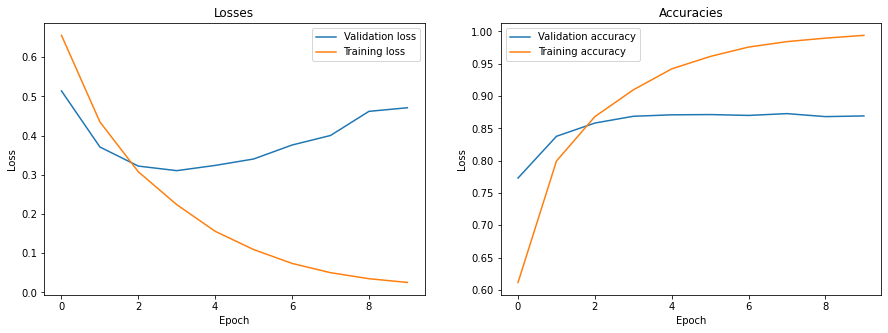

In [12]:
# Строим графики точности и потерь
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Оцениваем модель на тестовых данных
model.load_state_dict(torch.load('CNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.343 | Test Acc: 85.24%


### Проверяем модель

In [14]:
def sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    # Сопоставление слов со вложениями слов
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    # Получаем прогнозы
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [15]:
reviews = ['This is the best movie I have ever watched!', 
           'This is an okay movie', 
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model, review) for review in reviews]
scores

[0.9771446585655212, 0.35399019718170166, 0.02346784807741642]

In [16]:
tricky_reviews = ['This is not the best movie I have ever watched!', 
           'Some would say it is an okay movie, but I found it terrific.', 
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model, review) for review in tricky_reviews]
scores

[0.9113041758537292, 0.7324784398078918, 0.011178537271916866]